In [736]:
import pandas as pd
from pandas.io.json import json_normalize

import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

### Reading Data From Binance
🔗 Source: https://binance-docs.github.io/apidocs/spot/en/#kline-candlestick-data

Getting M5 and M1 to DataFrame

In [737]:
url_binance_bnbusdt_5m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=5m"
df_binance_bnbusdt_5m = pd.read_json(url_binance_bnbusdt_5m)

df_binance_bnbusdt_5m.columns = [
    '5m_open_time', 
    '5m_open_price', 
    '5m_high_price', 
    '5m_low_price', 
    '5m_close_price', 
    '5m_volume', 
    '5m_close_time', 
    '5m_quote_asset_volume', 
    '5m_number_of_trades', 
    '5m_taker_buy_base_asset_volume', 
    '5m_taker_buy_quote_asset_volume', 
    '5m_unused'
]

df_binance_bnbusdt_5m.head()

,5m_open_time,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_close_time,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,5m_unused
0,1665294900000,276.5,276.8,276.5,276.7,204.127,1665295199999,56478.9092,194,169.104,46790.5581,0
1,1665295200000,276.8,277.1,276.7,277.1,646.381,1665295499999,178951.8643,339,563.802,156095.0594,0
2,1665295500000,277.0,277.1,277.0,277.1,177.028,1665295799999,49049.7551,207,129.991,36020.5061,0
3,1665295800000,277.1,277.2,277.0,277.1,294.069,1665296099999,81498.2326,241,232.409,64413.0173,0
4,1665296100000,277.1,277.2,277.0,277.0,279.151,1665296399999,77349.9429,260,114.490,31731.3822,0


In [738]:
url_binance_bnbusdt_1m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=1m"
df_binance_bnbusdt_1m = pd.read_json(url_binance_bnbusdt_1m)

df_binance_bnbusdt_1m.columns = [
    '1m_open_time', 
    '1m_open_price', 
    '1m_high_price', 
    '1m_low_price', 
    '1m_close_price', 
    '1m_volume', 
    '1m_close_time', 
    '1m_quote_asset_volume', 
    '1m_number_of_trades', 
    '1m_taker_buy_base_asset_volume', 
    '1m_taker_buy_quote_asset_volume', 
    '1m_unused'
]

df_binance_bnbusdt_1m.head()

,1m_open_time,1m_open_price,1m_high_price,1m_low_price,1m_close_price,1m_volume,1m_close_time,1m_quote_asset_volume,1m_number_of_trades,1m_taker_buy_base_asset_volume,1m_taker_buy_quote_asset_volume,1m_unused
0,1665534900000,272.2,272.3,272.2,272.3,29.953,1665534959999,8155.8161,45,26.095,7105.6685,0
1,1665534960000,272.3,272.3,272.2,272.3,17.040,1665535019999,4639.4624,56,11.744,3197.8912,0
2,1665535020000,272.2,272.3,272.2,272.3,20.267,1665535079999,5517.3574,40,6.800,1851.6400,0
3,1665535080000,272.2,272.3,272.1,272.3,471.959,1665535139999,128460.9538,139,47.876,13031.8705,0
4,1665535140000,272.2,272.3,272.2,272.2,50.802,1665535199999,13832.1645,66,38.601,10511.0523,0


In [739]:
len(df_binance_bnbusdt_5m), len(df_binance_bnbusdt_1m)

(1000, 1000)

### Reading Rounds Data from Pancake Subgraph
🔗 Source: https://api.thegraph.com/subgraphs/name/pancakeswap/prediction-v2

Method: `POST`

Query:

{ query: "{ rounds(first: 1000 where: {position_not: null} orderBy: epoch,orderDirection:desc) {
    id
    epoch
    position
    failed
    startAt
    startBlock
    startHash
    lockAt
    lockBlock
    lockHash
    lockPrice
    lockRoundId
    closeAt
    closeBlock
    closeHash
    closePrice
    closeRoundId
    totalBets
    totalAmount
    bullBets
    bullAmount
    bearBets
    bearAmount
    }
}", }

In [740]:
pancake_subgraph_url = 'https://api.thegraph.com/subgraphs/name/pancakeswap/prediction-v2'
pancake_rounds_query = '{"query": "{ rounds(first: 1000 where: {position_not: null} orderBy: epoch,orderDirection:desc) { id epoch position failed startAt startBlock startHash lockAt lockBlock lockHash lockPrice lockRoundId closeAt closeBlock closeHash closePrice closeRoundId totalBets totalAmount bullBets bullAmount bearBets bearAmount } }"}'

In [741]:
import requests
req_pancake_rounds = requests.post(url=pancake_subgraph_url, data=pancake_rounds_query)

In [742]:
req_pancake_rounds

<Response [200]>

In [743]:
json_pancake_rounds = req_pancake_rounds.json()

In [744]:
len(json_pancake_rounds["data"]["rounds"])

1000

In [745]:
df_pancake_rounds = pd.DataFrame.from_dict(json_pancake_rounds["data"]["rounds"])

In [746]:
df_pancake_rounds.head()

,id,epoch,position,failed,startAt,startBlock,startHash,lockAt,lockBlock,lockHash,...,closeBlock,closeHash,closePrice,closeRoundId,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,111580,111580,Bear,False,1665591675,22116115,0x6fab753d5945f304cde59f21b2c177984ce466421ddd...,1665591984,22116218,0xb6f9d26f4bffcc056640562f2fd54cf84edea912c010...,...,22116321,0x0a8071cc6ee1bc563b1d7d9f4a312c6fe4619145be80...,270.24,18446744073711492435,103,29.111333709407959689,46,16.374583608906021076,57,12.736750100501938613
1,111579,111579,Bear,False,1665591369,22116013,0x165cf484346443483bf613d31203c150f312471765b8...,1665591675,22116115,0x6fab753d5945f304cde59f21b2c177984ce466421ddd...,...,22116218,0xb6f9d26f4bffcc056640562f2fd54cf84edea912c010...,270.29,18446744073711492421,109,30.388258679065375692,48,9.372920177241866685,61,21.015338501823509007
2,111578,111578,Bear,False,1665591062,22115911,0x234c625b8af7bf17a9dd6415186df66f1c114381c715...,1665591369,22116013,0x165cf484346443483bf613d31203c150f312471765b8...,...,22116115,0x6fab753d5945f304cde59f21b2c177984ce466421ddd...,270.40156382,18446744073711492405,84,21.207922302534098632,44,12.331257423427876956,40,8.876664879106221676
3,111577,111577,Bear,False,1665590753,22115808,0x225ab89e677dcea5d4ba77059d1bfbc57fe5b65a7b50...,1665591062,22115911,0x234c625b8af7bf17a9dd6415186df66f1c114381c715...,...,22116013,0x165cf484346443483bf613d31203c150f312471765b8...,270.77939334,18446744073711492391,88,22.704405155364319674,49,10.44966771586130123,39,12.254737439503018444
4,111576,111576,Bear,False,1665590444,22115705,0xcacb5ac905aea5d5d4562c896fc4f67d6cdf96c1b176...,1665590753,22115808,0x225ab89e677dcea5d4ba77059d1bfbc57fe5b65a7b50...,...,22115911,0x234c625b8af7bf17a9dd6415186df66f1c114381c715...,270.87,18446744073711492376,83,18.452408047942735176,43,8.83040186252406736,40,9.622006185418667816


In [747]:
# Create a key-column to join DataFrames
df_binance_bnbusdt_5m["timestamp_key"] = pd.to_datetime(df_binance_bnbusdt_5m["5m_close_time"], unit='ms')
df_binance_bnbusdt_1m["timestamp_key"] = pd.to_datetime(df_binance_bnbusdt_1m["1m_close_time"], unit='ms')
df_pancake_rounds["timestamp_key"] = pd.to_datetime(df_pancake_rounds["closeAt"], unit='s')

# Sort by join key
df_binance_bnbusdt_5m.sort_values('timestamp_key', inplace=True)
df_binance_bnbusdt_1m.sort_values('timestamp_key', inplace=True)
df_pancake_rounds.sort_values('timestamp_key', inplace=True)

In [748]:
# Join Dataframes
df_joined = pd.merge_asof(df_binance_bnbusdt_5m, df_pancake_rounds, on='timestamp_key',direction = 'nearest', tolerance=pd.Timedelta("5 min"))

# Remove Empty epoch column records
df_joined.dropna(subset=['epoch'], inplace=True)

df_joined.head()

,5m_open_time,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_close_time,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,...,closeBlock,closeHash,closePrice,closeRoundId,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,1665294900000,276.5,276.8,276.5,276.7,204.127,1665295199999,56478.9092,194,169.104,...,22018771,0x21a4885162667cb772159ca38a22c09b3e25b76fb485...,276.70542558,18446744073711478612,80,14.99212608149079424,35,4.734658182562263438,45,10.257467898928530802
1,1665295200000,276.8,277.1,276.7,277.1,646.381,1665295499999,178951.8643,339,563.802,...,22018866,0x3b649fdc6df52dbb76c7e49919063edd289da8740ae4...,276.88976235,18446744073711478624,82,20.894362864000019094,54,8.875731288220691,28,12.018631575779328094
2,1665295500000,277.0,277.1,277.0,277.1,177.028,1665295799999,49049.7551,207,129.991,...,22018970,0x178adba1212911a53d875944baa24eff9210575fe662...,277.07461212,18446744073711478637,80,15.00804106906864295,51,10.891326183383366121,29,4.116714885685276829
3,1665295800000,277.1,277.2,277.0,277.1,294.069,1665296099999,81498.2326,241,232.409,...,22019074,0x9379a754128fa395314f93bc2698bd2dbc9398a14b93...,277.1598707,18446744073711478652,85,15.98461373753676798,38,9.917541234656864525,47,6.067072502879903455
4,1665296100000,277.1,277.2,277.0,277.0,279.151,1665296399999,77349.9429,260,114.490,...,22019177,0xd68339b55852eccd3f8cd57d125f44832808626df76d...,277.13884483,18446744073711478667,59,6.874681954180625812,32,3.842499925985640389,27,3.032182028194985423


In [749]:
df_distinct = df_joined.drop_duplicates(['epoch'], keep='last')
df_distinct.head()

,5m_open_time,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_close_time,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,...,closeBlock,closeHash,closePrice,closeRoundId,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,1665294900000,276.5,276.8,276.5,276.7,204.127,1665295199999,56478.9092,194,169.104,...,22018771,0x21a4885162667cb772159ca38a22c09b3e25b76fb485...,276.70542558,18446744073711478612,80,14.99212608149079424,35,4.734658182562263438,45,10.257467898928530802
1,1665295200000,276.8,277.1,276.7,277.1,646.381,1665295499999,178951.8643,339,563.802,...,22018866,0x3b649fdc6df52dbb76c7e49919063edd289da8740ae4...,276.88976235,18446744073711478624,82,20.894362864000019094,54,8.875731288220691,28,12.018631575779328094
2,1665295500000,277.0,277.1,277.0,277.1,177.028,1665295799999,49049.7551,207,129.991,...,22018970,0x178adba1212911a53d875944baa24eff9210575fe662...,277.07461212,18446744073711478637,80,15.00804106906864295,51,10.891326183383366121,29,4.116714885685276829
3,1665295800000,277.1,277.2,277.0,277.1,294.069,1665296099999,81498.2326,241,232.409,...,22019074,0x9379a754128fa395314f93bc2698bd2dbc9398a14b93...,277.1598707,18446744073711478652,85,15.98461373753676798,38,9.917541234656864525,47,6.067072502879903455
4,1665296100000,277.1,277.2,277.0,277.0,279.151,1665296399999,77349.9429,260,114.490,...,22019177,0xd68339b55852eccd3f8cd57d125f44832808626df76d...,277.13884483,18446744073711478667,59,6.874681954180625812,32,3.842499925985640389,27,3.032182028194985423


In [750]:
# Exporting Data Frame
df_distinct.to_csv("dataset-to-predict.csv", index=False)

In [751]:
# Remove unused columns
df_predict = df_distinct.drop([
    '5m_open_time', 
    '5m_close_time', 
    '5m_unused', 
    'timestamp_key', 
    'id', 
    'epoch', 
    'failed', 
    'startAt', 
    'startBlock', 
    'startHash', 
    'lockAt', 
    'lockBlock', 
    'lockHash', 
    'lockRoundId', 
    'closeAt', 
    'closeBlock', 
    'closeHash', 
    'closeRoundId'], axis=1)


df_predict.head()

,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,position,lockPrice,closePrice,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,276.5,276.8,276.5,276.7,204.127,56478.9092,194,169.104,46790.5581,Bull,276.59012997,276.70542558,80,14.99212608149079424,35,4.734658182562263438,45,10.257467898928530802
1,276.8,277.1,276.7,277.1,646.381,178951.8643,339,563.802,156095.0594,Bull,276.70542558,276.88976235,82,20.894362864000019094,54,8.875731288220691,28,12.018631575779328094
2,277.0,277.1,277.0,277.1,177.028,49049.7551,207,129.991,36020.5061,Bull,276.88976235,277.07461212,80,15.00804106906864295,51,10.891326183383366121,29,4.116714885685276829
3,277.1,277.2,277.0,277.1,294.069,81498.2326,241,232.409,64413.0173,Bull,277.07461212,277.1598707,85,15.98461373753676798,38,9.917541234656864525,47,6.067072502879903455
4,277.1,277.2,277.0,277.0,279.151,77349.9429,260,114.490,31731.3822,Bear,277.1598707,277.13884483,59,6.874681954180625812,32,3.842499925985640389,27,3.032182028194985423


In [752]:
df_predict["lockPrice"] = pd.to_numeric(df_predict["lockPrice"])
df_predict["closePrice"] = pd.to_numeric(df_predict["closePrice"])
df_predict["totalBets"] = pd.to_numeric(df_predict["totalBets"])
df_predict["totalAmount"] = pd.to_numeric(df_predict["totalAmount"])
df_predict["bullBets"] = pd.to_numeric(df_predict["bullBets"])
df_predict["bullAmount"] = pd.to_numeric(df_predict["bullAmount"])
df_predict["bearBets"] = pd.to_numeric(df_predict["bearBets"])
df_predict["bearAmount"] = pd.to_numeric(df_predict["bearAmount"])
df_predict.head()

,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,position,lockPrice,closePrice,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,276.5,276.8,276.5,276.7,204.127,56478.9092,194,169.104,46790.5581,Bull,276.590130,276.705426,80,14.992126,35,4.734658,45,10.257468
1,276.8,277.1,276.7,277.1,646.381,178951.8643,339,563.802,156095.0594,Bull,276.705426,276.889762,82,20.894363,54,8.875731,28,12.018632
2,277.0,277.1,277.0,277.1,177.028,49049.7551,207,129.991,36020.5061,Bull,276.889762,277.074612,80,15.008041,51,10.891326,29,4.116715
3,277.1,277.2,277.0,277.1,294.069,81498.2326,241,232.409,64413.0173,Bull,277.074612,277.159871,85,15.984614,38,9.917541,47,6.067073
4,277.1,277.2,277.0,277.0,279.151,77349.9429,260,114.490,31731.3822,Bear,277.159871,277.138845,59,6.874682,32,3.842500,27,3.032182


In [753]:
# Change position column to 0 or 1 column
df_predict["position_code"] = pd.Categorical(df_predict.position).codes
df_predict.drop("position", axis=1, inplace=True)

In [754]:
# Create a column transformer
ct = make_column_transformer(
    (MinMaxScaler(), ["5m_open_price", "5m_high_price", "5m_low_price", "5m_close_price", "5m_volume", "5m_quote_asset_volume", "5m_number_of_trades", "5m_taker_buy_base_asset_volume", "5m_taker_buy_quote_asset_volume", "lockPrice", "closePrice", "totalBets", "totalAmount", "bullBets", "bullAmount", "bearBets", "bearAmount"]), # turn all values in these columns between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), [])
)

In [755]:
# Create X & y values

# The X (independent variables) will be every column of DataFrame except charges
X_read = df_predict.drop("position_code", axis=1)

# The y (dependent or label) is charges column
y_read = df_predict["position_code"]

In [756]:
# The position Bear or Bull is for the next, so we'll shift removing first row of y and last row for X

# Drop first row of y
y = y_read.drop(index=y_read.index[0], axis=0)

# Drop last row of X
X = X_read.drop(index=X_read.index[-1], axis=0)

In [757]:
# Split dataset in random set to train using sklearn
# Separate 20% (0.2) for test and 80% to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [758]:
len(X_train), len(X_test), len(y_train), len(y_test)

(768, 193, 768, 193)

In [759]:
X_train.head()

,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,lockPrice,closePrice,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
482,274.8,274.9,272.2,272.8,6602.524,1.802163e+06,4040,2334.828,636926.8005,274.675215,272.940237,69,11.971907,38,8.705123,31,3.266784
952,270.3,270.4,270.1,270.3,507.268,1.370773e+05,524,216.288,58456.5718,270.170000,270.324083,76,13.347134,45,9.277610,31,4.069524
566,269.7,270.3,269.7,270.2,455.630,1.229794e+05,359,339.188,91562.0480,269.850000,270.000000,70,12.378320,38,7.645165,32,4.733156
288,277.2,277.4,277.1,277.2,585.735,1.623951e+05,251,185.166,51352.2785,277.236510,277.200369,77,12.356677,35,6.011891,42,6.344786
112,278.8,279.1,278.7,279.1,568.754,1.586249e+05,514,310.853,86707.2139,278.807655,279.052780,104,27.035806,61,20.542764,43,6.493042


In [760]:
# Fit the column transformer to our training data
ct.fit(X_train)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['5m_open_price', '5m_high_price',
                                  '5m_low_price', '5m_close_price', '5m_volume',
                                  '5m_quote_asset_volume',
                                  '5m_number_of_trades',
                                  '5m_taker_buy_base_asset_volume',
                                  '5m_taker_buy_quote_asset_volume',
                                  'lockPrice', 'closePrice', 'totalBets',
                                  'totalAmount', 'bullBets', 'bullAmount',
                                  'bearBets', 'bearAmount']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'), [])])

In [761]:
# Transform training and test data with normalization (MinMaxScaler) and OneHotEncoder
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [762]:
# What does our data look like now?
X_train.loc[0], X_train_normal[0]

(5m_open_price                        276.500000
 5m_high_price                        276.800000
 5m_low_price                         276.500000
 5m_close_price                       276.700000
 5m_volume                            204.127000
 5m_quote_asset_volume              56478.909200
 5m_number_of_trades                  194.000000
 5m_taker_buy_base_asset_volume       169.104000
 5m_taker_buy_quote_asset_volume    46790.558100
 lockPrice                            276.590130
 closePrice                           276.705426
 totalBets                             80.000000
 totalAmount                           14.992126
 bullBets                              35.000000
 bullAmount                             4.734658
 bearBets                              45.000000
 bearAmount                            10.257468
 Name: 0, dtype: float64,
 array([0.59292035, 0.58333333, 0.41666667, 0.4159292 , 0.56000349,
        0.55737716, 0.77435487, 0.5530724 , 0.5506311 , 0.57213299,
     

In [1049]:
# Build a neural network model to fit on our normalized data

tf.random.set_seed(42)

# 1. Create the model (based on insurance_model_2)
model_a = tf.keras.Sequential([
    tf.keras.layers.Dense(100, name="hidden_layer_1", activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(9, name="hidden_layer_2", activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, name="hidden_layer_3", activation=tf.keras.activations.relu),
    # tf.keras.layers.Dense(5, name="hidden_layer_3"),
    # tf.keras.layers.Dense(5, name="hidden_layer_4"),
    tf.keras.layers.Dense(1, name="output_layer", activation=tf.keras.activations.linear)
], name="model_a")

# 2. Compile the model
model_a.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                          metrics=["mae"])

# 3. Fit the model
history_model_a = model_a.fit(X_train_normal, y_train, epochs=100, verbose=0)

In [1050]:
model_a.summary()

Model: "model_a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (32, 100)                 1800      
                                                                 
 hidden_layer_2 (Dense)      (32, 9)                   909       
                                                                 
 hidden_layer_3 (Dense)      (32, 1)                   10        
                                                                 
 output_layer (Dense)        (32, 1)                   2         
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


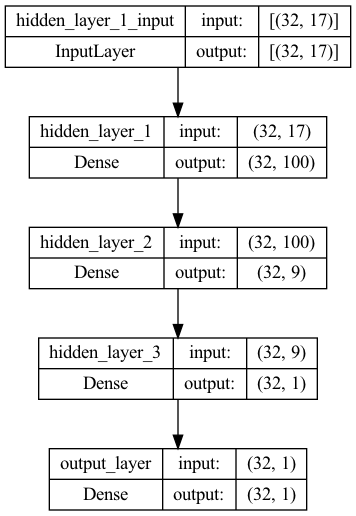

In [1051]:
plot_model(model_a, show_shapes=True)

In [1052]:
# Evaluate our insurance model trained on normalized data

evaluate_result = model_a.evaluate(X_test_normal, y_test)
evaluate_result[0]

7/7 [==============================] - 0s 894us/step - loss: 0.2633 - mae: 0.5050


0.26327434182167053

### Best result
* 100 (relu) -> 10 (relu) -> 1 (relu) -> 1 (output linear)
* Adam(learning_rate: 0.001)
* loss mse
* Epochs: 200

0.2500512897968292

Text(0.5, 0, 'epochs')

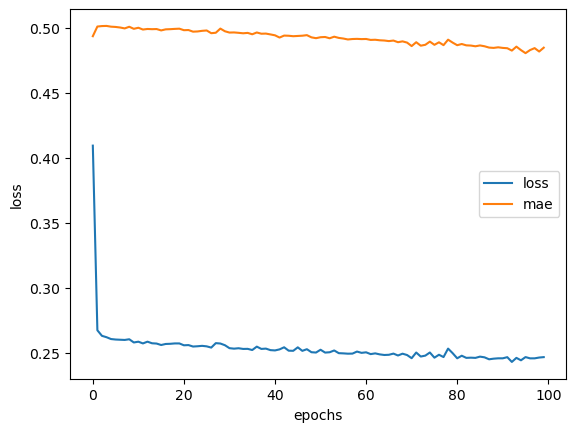

In [1053]:
# Plot history (also known as a loss curve or training curve)
pd.DataFrame(history_model_a.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [1008]:
# Save model using the SavedModel format
!mkdir -p saved_model
model_a.save('saved_model/prediction_linear_regression_model_a')

INFO:tensorflow:Assets written to: saved_model/prediction_linear_regression_model_a/assets


In [934]:
# Save model using the HDF5 format
!mkdir -p hdf5

# The '.h5' extension indicates that the model should be saved to HDF5
model_a.save('hdf5/prediction_linear_regression_model_a.h5')